<a href="https://colab.research.google.com/github/UlasSen/NLP/blob/main/Bert/BertTextClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [6]:
import pandas as pd

df = pd.read_csv("spam.csv", encoding="latin1")
df.head(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [7]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
df.head(5)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
df.rename(columns={'v1': 'Category', 'v2': 'Message'}, inplace=True)
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
df.groupby('Category').describe()


Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    653  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [10]:
df['spam']=df['Category'].apply(lambda x: 1 if x=='spam' else 0)
df.head()

,Category,Message,spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['Message'],df['spam'], stratify=df['spam'])

In [12]:
X_train.head(4)

,Message
5124,He is impossible to argue with and he always t...
1698,"Free msg. Sorry, a service you ordered from 81..."
714,He also knows about lunch menu only da. . I know
4076,Hey sathya till now we dint meet not even a si...


In [13]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")


In [14]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up",
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.843517  , -0.5132727 , -0.8884572 , ..., -0.7474886 ,
        -0.75314724,  0.91964495],
       [-0.8720834 , -0.50543964, -0.94446665, ..., -0.8584749 ,
        -0.7174534 ,  0.88082975]], dtype=float32)>

In [15]:
e = get_sentence_embeding([
    "banana",
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

In [16]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]])

array([[0.9911088]], dtype=float32)

In [17]:
cosine_similarity([e[0]],[e[4]])

array([[0.8933631]], dtype=float32)

In [18]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                              

In [20]:
len(X_train)

4179

In [21]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [22]:
#Training the model
model.fit(X_train, y_train, epochs=10)


Epoch 1/10
131/131 [==============================] - 53s 328ms/step - loss: 0.3288 - accuracy: 0.8648 - precision: 0.4390 - recall: 0.0321
Epoch 2/10
131/131 [==============================] - 46s 352ms/step - loss: 0.2403 - accuracy: 0.8904 - precision: 0.7802 - recall: 0.2536
Epoch 3/10
131/131 [==============================] - 45s 346ms/step - loss: 0.2054 - accuracy: 0.9153 - precision: 0.8323 - recall: 0.4607
Epoch 4/10
131/131 [==============================] - 47s 360ms/step - loss: 0.1774 - accuracy: 0.9316 - precision: 0.8703 - recall: 0.5750
Epoch 5/10
131/131 [==============================] - 46s 350ms/step - loss: 0.1628 - accuracy: 0.9416 - precision: 0.8744 - recall: 0.6589
Epoch 6/10
131/131 [==============================] - 46s 348ms/step - loss: 0.1486 - accuracy: 0.9490 - precision: 0.8934 - recall: 0.7036
Epoch 7/10
131/131 [==============================] - 45s 346ms/step - loss: 0.1366 - accuracy: 0.9521 - precision: 0.9036 - recall: 0.7196
Epoch 8/10
131/131 [

In [23]:
model.evaluate(X_test, y_test)


44/44 [==============================] - 16s 345ms/step - loss: 0.0984 - accuracy: 0.9706 - precision: 0.9679 - recall: 0.8075


[0.09841877222061157,
 0.9705671072006226,
 0.9679487347602844,
 0.8074866533279419]

In [24]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

44/44 [==============================] - 16s 356ms/step


In [25]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 0, ..., 0, 0, 1])

In [26]:

from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[1201,    5],
       [  36,  151]])

Text(50.722222222222214, 0.5, 'Truth')

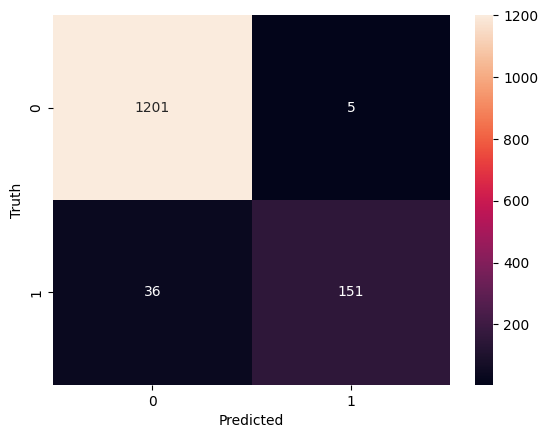

In [27]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [28]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1206
           1       0.97      0.81      0.88       187

    accuracy                           0.97      1393
   macro avg       0.97      0.90      0.93      1393
weighted avg       0.97      0.97      0.97      1393



In [29]:
#INFERENCE(SONUÇ)
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 1s 1s/step


array([[0.5662978 ],
       [0.7185331 ],
       [0.38442427],
       [0.02832151],
       [0.00880939]], dtype=float32)